# Stable Diffusion Upscaling: How to run inference on the endpoint you have created?

Importing relevant packages for querying endpoint and image visualization

In [ ]:
# import matplotlib.pyplot as plt
# from IPython.core.display import HTML
# import numpy as np
# import json
# from io import BytesIO

In [ ]:
!pip install -U 'stability-sdk[sagemaker] @ git+https://github.com/Stability-AI/stability-sdk.git@sagemaker'
!pip install protobuf==3.20

In [11]:
import sagemaker
from sagemaker import ModelPackage, get_execution_role
from stability_sdk_sagemaker.predictor import StabilityPredictor
from stability_sdk_sagemaker.models import get_model_package_arn
from stability_sdk.api import GenerationRequest, GenerationResponse, TextPrompt

import matplotlib.pyplot as plt
from IPython.core.display import HTML
import numpy as np
import json
from io import BytesIO

from PIL import Image
from typing import Union, Tuple
import io
import os
import base64
import boto3

In [15]:
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad"
}


region = boto3.Session().region_name
if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")
package_arn = model_package_map[region]  # TODO

role_arn = get_execution_role()
sagemaker_session = sagemaker.Session()

# Generate low-resolution image

In [18]:
# Set your SDXL endpoint name
endpoint_name="sdxl-1-0-jumpstart-2023-08-18-19-32-18-401"

In [19]:
deployed_model = StabilityPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)

In [23]:
prompt = "Create an image of a green iguana in the Amazon rainforest"

In [36]:
image_name_1 = "{}.png".format(prompt.replace(" ", "_"))
image_name_1

'Create_an_image_of_a_green_iguana_in_the_Amazon_rainforest.png'

In [37]:
output = deployed_model.predict(
    GenerationRequest(text_prompts=[TextPrompt(text=prompt)],
                      style_preset="photographic",
                      seed = 42,
                      width=512,
                      height=512
                     )
)

In [38]:
def decode_and_show(model_response: GenerationResponse, image_name) -> None:
    """
    Decodes and displays an image from SDXL output

    Args:
        model_response (GenerationResponse): The response object from the deployed SDXL model.

    Returns:
        None
    """
    image = model_response.artifacts[0].base64
    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(image_data))
    image.save(image_name)
    display(image)

## Show generated (high-res) image

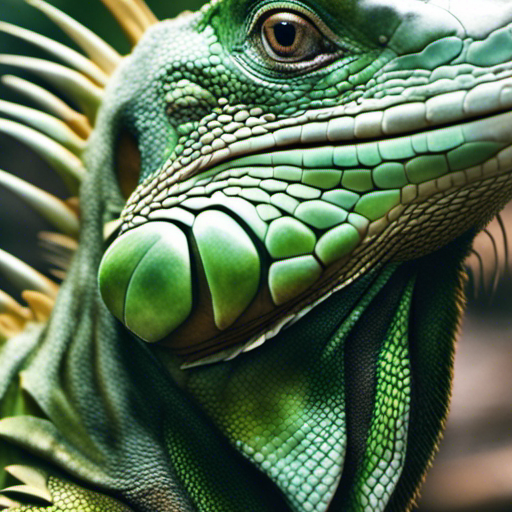

In [39]:
decode_and_show(output, image_name_1)

## Manually convert this image in 128x128px, 10% quality JPG

In [40]:
low_res_img_file_name = "green_iguana_lowres.jpg"

In [ ]:
display(Image.open(low_res_img_file_name))

### Query endpoint

***
Next, we query the endpoint to upscale the low resolution cat image and display the image generated by the model. You can put in any text and any image and the model generates the corresponding upscaled image. Note that model generates an image of size up to four times the original image. So, putting a very large input image may result in CUDA memory issue. To address this, either input a low resolution image or select an instance type with larger CUDA memory such as ml.g5.2xlarge.
***

In [41]:
endpoint_name = 'jumpstart-dft-stable-diffusion-x4-upscaler-fp16'

with open(low_res_img_file_name,'rb') as f: low_res_image_bytes = f.read()
encoded_image = base64.b64encode(bytearray(low_res_image_bytes)).decode()

payload = { "prompt":"a green iguana", "image": encoded_image,  "num_inference_steps":50, "guidance_scale":7.5}

def query_endpoint(payload):
    """query the endpoint with the json payload encoded in utf-8 format."""
    
    client = boto3.client('runtime.sagemaker')
    # Accept = 'application/json;jpeg' returns the jpeg image as bytes encoded by base64.b64 encoding.
    # To receive raw image with rgb value set Accept = 'application/json'
    # To send raw image, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open('low_res_image.jpg')).tolist()
    # Note that sending or receiving payload with raw/rgb values may hit default limits for the input payload and the response size.
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json;jpeg', Accept = 'application/json;jpeg', Body=payload)
    return response

def parse_response(query_response):
    """Parse the endpoint response and returns the generated image and the original prompt"""
    
    response_dict = json.loads(query_response['Body'].read())
    return response_dict['generated_images'], response_dict['prompt']

query_response = query_endpoint(json.dumps(payload).encode('utf-8'))
generated_images, prompt = parse_response(query_response)

Next, we display the generated image

In [44]:
def display_image(img, title):
    plt.figure(figsize=(12,12))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title(title)
    plt.show()

In [51]:
def display_save_image(img, title):
#    image = model_response.artifacts[0].base64
#    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(img))
    image.save("upscaled-image.png")
    display(image)

## Show low-res image

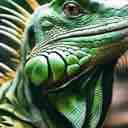

In [46]:
display(Image.open("green_iguana_lowres.jpg"))

In [54]:
HTML('<table><tr><td> <img src="green_iguana_lowres.jpg" alt="iguana" style="height: 512px;"/> <figcaption>original low resolution image</figcaption>'
     '</td></tr></table>')

original low resolution image


## Show upscaled image

In [49]:
image_name_2 = "upscaled_green_iguana.png"

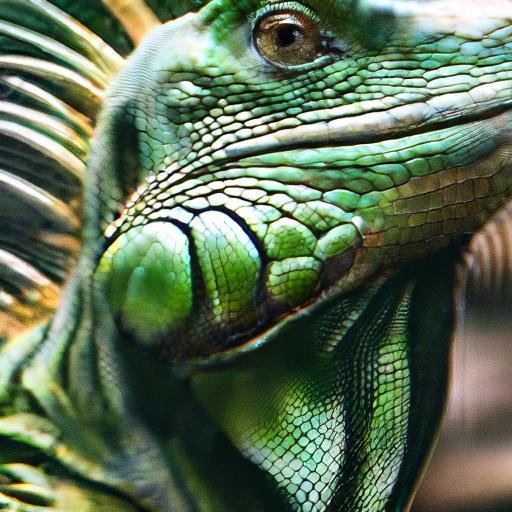

In [56]:
for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
    generated_image_rgb.save(image_name_2)
    display(generated_image_rgb)

In [53]:
# for generated_image in generated_images:
#     generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
#     generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
#     display_image(generated_image_rgb, "upscaled image generated by model")

### Supported parameters

***
This model supports many parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **num_inference_steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.
* **noise_level**: add noise to latent vectors before upscaling. If specified, it must be an integer.

***